## Стратегии обучения RL

В контексте обучения с подкреплением (Reinforcement Learning, RL), стратегии обучения модели определяют, каким образом агент исследует окружение и выбирает действия для максимизации награды. Эти стратегии разделяются на Exploration (исследование) и Exploitation (использование) и направлены на достижение баланса между изучением новых стратегий и максимизацией текущих знаний.
В обучении с подкреплением присутствует баланс между Exploration и Exploitation. Exploration включает в себя стратегии, направленные на изучение новых действий или состояний, чтобы расширить базу знаний. Exploitation, наоборот, использует текущие знания для выбора оптимальных действий и максимизации награды. Нахождение оптимального баланса между Exploration и Exploitation - ключевой аспект в достижении успешных стратегий обучения с подкреплением.
В данной работе мы рассмотрим различные стратегии и их влияние на обучение агента с использованием библиотек Gymnasium и Stable-Baseline3.

### Подготовка среды и библиотек

Установим необходимые библиотеки и создадим среду CartPole для экспериментов

In [19]:
# !pip install gymnasium
!pip install stable-baselines3
!pip install swig
!pip install gymnasium[box2d]

  Using cached swig-4.1.1.post1-py2.py3-none-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.8 MB)
  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2373075 sha256=1d6b36a8a04f6412b5ffe0b338dc97378368a0df5e078b5c6bf446a2e3c28885
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py


In [20]:
import gymnasium as gym
from stable_baselines3 import SAC,DDPG
import numpy as np
import matplotlib.pyplot as plt

In [21]:
# Создание окружения "CarRacing-v2"
env_name = 'CarRacing-v2'
env = gym.make(env_name, render_mode="human")

### Исследование различных стратегий
Исследуем влияние различных стратегий исследования на процесс обучения агента.

#### Epsilon-Greedy

Epsilon-Greedy - это одна из базовых стратегий исследования в обучении с подкреплением. Агент принимает решение о выборе действия с учетом двух возможных вариантов: с высокой вероятностью (1-epsilon) агент выбирает действие с максимальной оценкой (использование), а с низкой вероятностью (epsilon) - случайное действие (исследование). Это позволяет агенту совмещать использование текущих знаний с возможностью исследования новых стратегий.

In [22]:
def epsilon_greedy(Q_values, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice(len(Q_values))  # Исследование
    else:
        return np.argmax(Q_values)  # Использование

#### Softmax
Стратегия Softmax представляет собой метод, который преобразует оценки ценности действий в вероятности их выбора. Эта стратегия учитывает "мягкость" выбора, регулируемую параметром температуры. При высокой температуре вероятности всех действий приближаются друг к другу, что способствует более случайному выбору (исследование), в то время как при низкой температуре выбирается действие с наибольшей оценкой (использованию).

In [23]:
def softmax(Q_values, temperature):
    exp_values = np.exp((Q_values - np.max(Q_values)) / temperature)
    probabilities = exp_values / exp_values.sum()
    return np.random.choice(len(Q_values), p=probabilities)

#### UCB1 (Upper Confidence Bound)
Стратегия UCB1 основана на оценке верхней границы для ценности действий. Агент выбирает действие, которое имеет максимальную смешанную оценку ценности и уверенность в этой оценке. Параметр, который регулирует уровень исследования, зависит от логарифма общего числа выполненных шагов.

In [24]:
def ucb1(Q_values, counts, total_counts):
    ucb_values = Q_values + np.sqrt((2 * np.log(total_counts)) / counts)
    return np.argmax(ucb_values)

Каждая из этих стратегий нацелена обеспечивать баланс между исследованием (поиск новых стратегий) и эксплуатацией (использование текущих знаний) в процессе обучения с подкреплением. Выбор конкретной стратегии зависит от характеристик задачи и предпочтений, таких как уровень исследования, требуемый для успешного обучения агента.

### Тестирование различных стратегий
На этом шаге мы рассмотрим модели реализующие некоторые из этих стратегий

#### DDPG
[DDPG](https://stable-baselines3.readthedocs.io/en/master/modules/ddpg.html) использует epsilon-greedy стратегию, добавляя шум к выбранному действию во время исследования.

In [ ]:
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise

n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

model = DDPG("MlpPolicy", env, action_noise=action_noise, verbose=1)
model.learn(total_timesteps=5000, log_interval=1)
model.save("ddpg_strategy")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 55.32GB > 12.03GB
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -30.5    |
| time/              |          |
|    episodes        | 1        |
|    fps             | 23       |
|    time_elapsed    | 43       |
|    total_timesteps | 1000     |
---------------------------------


In [ ]:
import gym
from IPython import display
from pyvirtualdisplay import Display
from matplotlib import animation

del model
timestamp = 1000

model = DDPG.load("ddpg_strategy")
ddpg_reward = []

d = Display()
d.start()

env = gym.make(env_name)

obs = env.reset()

img = []
for i in range(timestamp):
    action, _states = model.predict(obs)
    obs, reward, terminated, truncated = env.step(action)
    ddpg_reward.append(reward)

    display.clear_output(wait=True)
    img.append(env.render('rgb_array'))

    if d:
        env.reset()

dpi = 72
interval = 1 # ms

plt.figure(figsize=(img[0].shape[1]/dpi,img[0].shape[0]/dpi),dpi=dpi)
patch = plt.imshow(img[0])
plt.axis=('off')
animate = lambda i: patch.set_data(img[i])
ani = animation.FuncAnimation(plt.gcf(),animate,frames=len(img),interval=interval)
display.display(display.HTML(ani.to_jshtml()))
env.close()

#### SAC
Стратегия исследования softmax применяется через термин энтропии в [SAC](https://stable-baselines3.readthedocs.io/en/master/modules/sac.html). Термин энтропия поощряет мягкое, вероятностное распределение действий, способствуя исследованию.

In [ ]:
import gymnasium as gym
# Создание окружения env_name
env = gym.make(env_name, render_mode="rgb_array")
model = SAC("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=5000, log_interval=1)
model.save("sac_strategy")

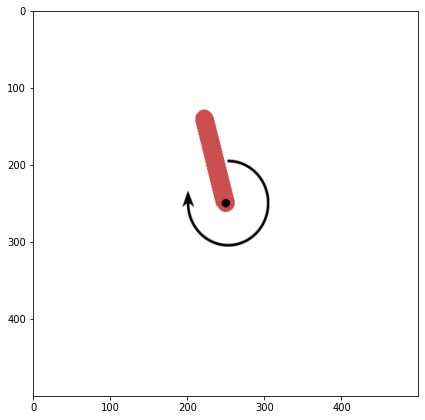

In [ ]:
import gym
del model

model = SAC.load("sac_strategy")
sac_reward = []

d = Display()
d.start()

env = gym.make(env_name)

obs = env.reset()

img = []
for i in range(timestamp):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated = env.step(action)
    sac_reward.append(reward)

    display.clear_output(wait=True)
    img.append(env.render('rgb_array'))

    if d:
        env.reset()

dpi = 72
interval = 1 # ms

plt.figure(figsize=(img[0].shape[1]/dpi,img[0].shape[0]/dpi),dpi=dpi)
patch = plt.imshow(img[0])
plt.axis=('off')
animate = lambda i: patch.set_data(img[i])
ani = animation.FuncAnimation(plt.gcf(),animate,frames=len(img),interval=interval)
display.display(display.HTML(ani.to_jshtml()))
env.close()

Примеры выше демонстрируют возможность решить одну и ту же задачу с помощью двух моделей различных моделей, которые используют расмотренные ранее стратегии. Далее построим график, который отображает процесс обучения этих моделей.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


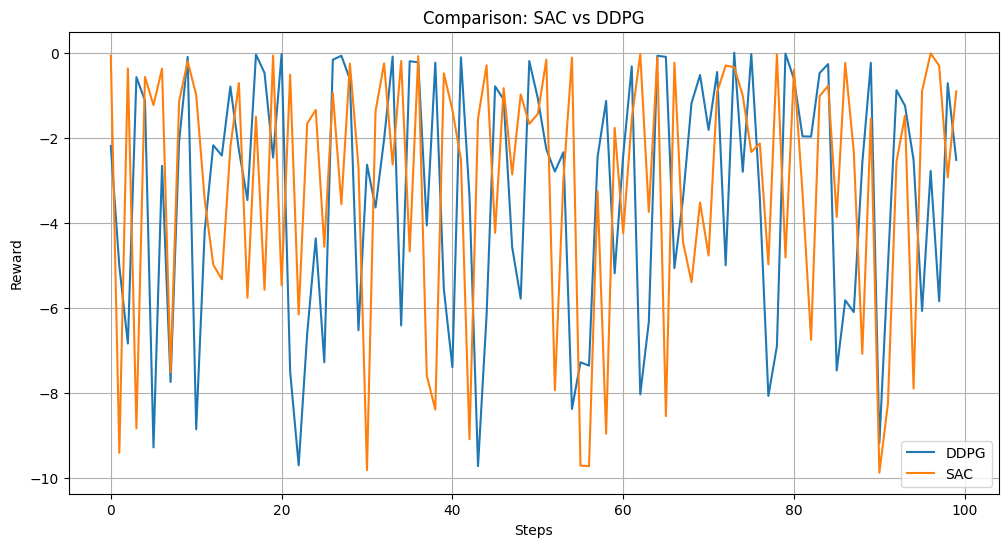

In [ ]:
def plot_training_results(model_logs, model_names, total_steps=100):
    plt.figure(figsize=(12, 6))
    for i, logs in enumerate(model_logs):
        plt.plot(np.arange(0, total_steps, 1), logs["reward"][:total_steps], label=model_names[i])

    plt.title("Comparison: SAC vs DDPG")
    plt.xlabel("Steps")
    plt.ylabel("Reward")
    plt.legend()
    plt.grid(True)
    plt.show()

ddpg_logs = {"reward": []}
sac_logs = {"reward": []}

ddpg_logs["reward"] = ddpg_reward

sac_logs["reward"] = sac_reward

plot_training_results([ddpg_logs, sac_logs], ["DDPG", "SAC"])



### Исследование влияния Learning Rate

Learning Rate (LR) является одним из ключевых гиперпараметров алгоритмов обучения с подкреплением, включая алгоритм Soft Actor-Critic (SAC). Этот параметр оказывает значительное влияние на эффективность обучения и способность алгоритма адаптироваться к изменениям в окружающей среде.

Learning Rate определяет размер шага, с которым модель обновляет свои веса в процессе градиентного спуска. В случае SAC, который является алгоритмом глубокого обучения, правильный выбор Learning Rate может определить успешность сходимости модели и её способность обучаться оптимальной стратегии.

В данном блоке мы рассмотрим важность параметра Learning Rate для алгоритма SAC, исследуем, как различные значения этого параметра могут влиять на процесс обучения. Далее мы представим код, который демонстрирует обучение модели SAC при различных значениях Learning Rate, а также проанализируем графики, позволяющие визуально оценить влияние этого параметра.

In [ ]:
import gymnasium as gym
# Создание среды CarRacing из Gym
env = gym.make(env_name)

# Список learning rate, которые вы хотите проверить
learning_rates = [0.0001, 0.001, 0.01]
sac_reward = {0.0001:[],0.001:[],0.01:[]}

# Итерация по разным learning rates
for lr in learning_rates:
    # Создание модели SAC с заданным learning rate
    model = SAC('MlpPolicy', env, learning_rate=lr, verbose=1)

    # Обучение модели
    model.learn(total_timesteps=5000)

    # Сохранение обученной модели
    model.save(f'sac_strategy_lr_{lr}')
    obs, info = env.reset()
    for i in range(50):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)
        sac_reward[lr].append(reward)
        if terminated or truncated:
            obs, info = env.reset()

# Закрытие среды
env.close()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 200       |
|    ep_rew_mean     | -1.38e+03 |
| time/              |           |
|    episodes        | 4         |
|    fps             | 37        |
|    time_elapsed    | 21        |
|    total_timesteps | 800       |
| train/             |           |
|    actor_loss      | 20.8      |
|    critic_loss     | 1.01      |
|    ent_coef        | 0.933     |
|    ent_coef_loss   | -0.105    |
|    learning_rate   | 0.0001    |
|    n_updates       | 699       |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 200       |
|    ep_rew_mean     | -1.51e+03 |
| time/              |           |
|    episodes        | 8         |
|    fps             | 34        |
|    time_elapsed    | 45        |
|    total_timesteps | 1600    

Проанализировав логи обучения модели можно увидеть, что выбор параметра learning_rate влияет, например, на время обучения модели.
Так же можно посчитать средний reward для различных значений learning_rate

In [ ]:
print(sum(sac_reward[0.0001])/len(sac_reward[0.0001]))
print(sum(sac_reward[0.001])/len(sac_reward[0.001]))
print(sum(sac_reward[0.01])/len(sac_reward[0.01]))

-5.824807576304836
-5.7785046338340464
-0.0109904691652454


Представим результаты reward для моделей обученных с различным learning_rate на графике

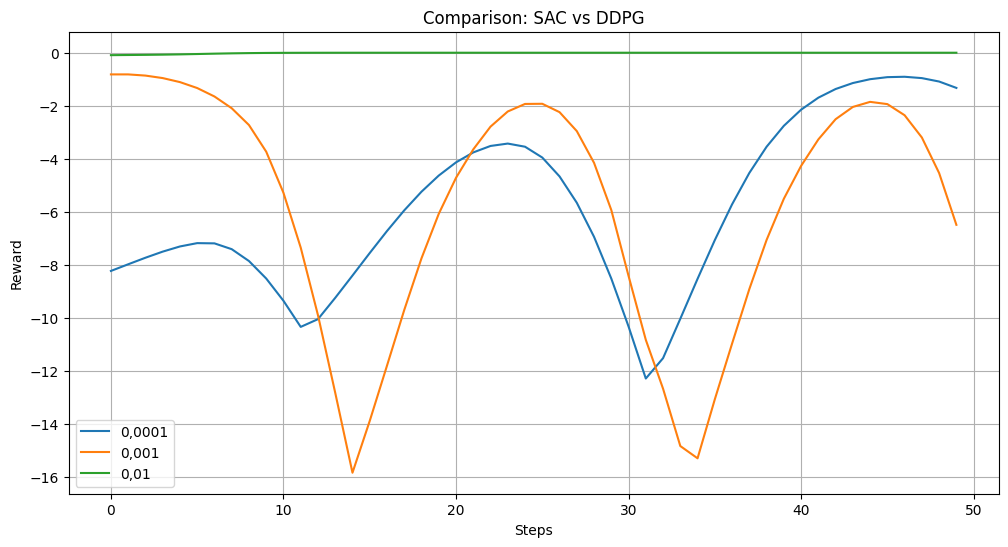

In [ ]:
sac_e4,sac_e3,sac_e2 = {}, {}, {}

sac_e4["reward"] = sac_reward[0.0001]

sac_e3["reward"] = sac_reward[0.001]

sac_e2["reward"] = sac_reward[0.01]
plot_training_results([sac_e4, sac_e3, sac_e2], ["0,0001", "0,001", "0,01"], total_steps=50)

Изменение параметра learning_rate при обучении алгоритма может существенно влиять на его производительность.

#### Маленький learning rate:

Обучение будет медленным, так как обновления весов модели будут небольшими.
Может потребоваться больше времени для достижения сходимости.
Существует риск застревания в локальных минимумах.

#### Средний learning rate:

Может оказаться хорошим компромиссом между скоростью обучения и стабильностью.
Быстрее, чем маленький learning_rate, но может все еще требовать достаточно большое количество времени для сходимости. Требует аккуратного подбора значения.

#### Большой learning rate:
Обучение в среднем будет быстрее, так как веса модели обновляются с большими шагами.
Может привести к нестабильному обучению, особенно если learning rate слишком велик.
Существует риск "перепрыгивания" оптимальных значений, что может замедлить или прервать сходимость.

#### Рекомендации
Начинать с относительно небольшого learning rate и постепенно увеличивать его, наблюдая за производительностью алгоритма. Можно также попробовать методы настройки гиперпараметров, чтобы автоматически подобрать оптимальные значения learning rate.

Помните, что результаты могут зависеть от конкретной задачи и структуры среды, поэтому рекомендуется проводить несколько экспериментов и внимательно анализировать результаты.

В данной лабораторной работе мы исследовали различные стратегии и влияние learning_rate на процесс обучения агента. Эксперименты позволяют нам понять, что различные стратегии и параметры лучше подходят для разных задач.
В качестве самостоятельной работы вы может дополнительно провести свои эксперименты, изменяя параметры и используя различные стратегии, чтобы более глубоко понять их влияние на обучение модели. Например, попробовать использовать одну из используемых в данной работе моделей на другом окружении Gym.